In [1]:
import h5py
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
fname = "R0_saturation.hdf"

In [3]:
def gaussian(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def set_fontsize(ax, fs):
    ax.title.set_fontsize(fs*1.3)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs/1.25)

In [5]:
def load_saturation_data(fname, dset_name):
    # loading data from HDF file
    with h5py.File(fname, 'r') as f:
        laserlock = f[dset_name]['readout']['Laser Lock'][()]
        wavelength = f[dset_name]['readout']['Wavelength'][()]
        pxie = {}
        for dset in f[dset_name]['readout']['PXIe-5171']:
            if 'events' not in dset:
                pxie[int(dset.split('_')[-1])] = f[dset_name]['readout']['PXIe-5171'][dset][()]
        
    integrated = []
    for i in range(1,max(pxie.keys())+1):
        integrated.append(-np.trapz((pxie[i][:,1] - pxie[i][:,1][50:250].mean())[250:1750]))
    return integrated, laserlock, wavelength

In [6]:
dset_names = [
    "1582155083 R0_F2_32mW",
    "1582155105 R0_F2_32mW",
    "1582155267 R0_F2_23mW",
    "1582155408 R0_F2_17mW",
    "1582155660 R0_F2_24mW",
    "1582155799 R0_F2_32mW",
    "1582155943 R0_F2_13mW",
    "1582156158 R0_F2_9mW",
    "1582156409 R0_F2_6mW",
    "1582156782 R0_F2_5mW"
]

powers = [
    32, 32, 23, 17, 24, 32, 13, 9, 6, 5
]

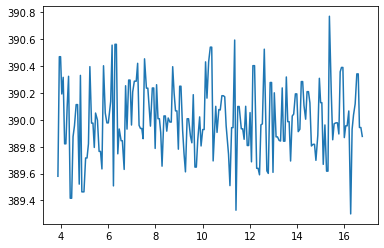

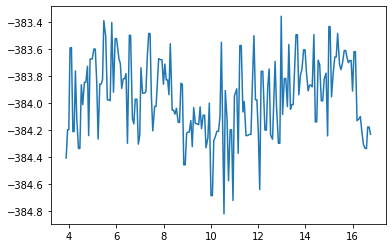

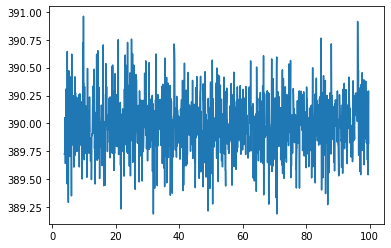

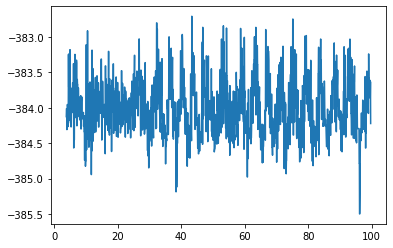

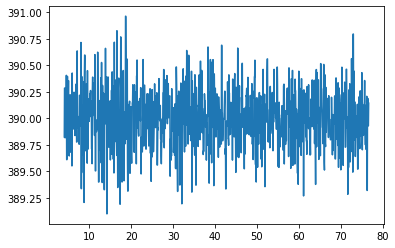

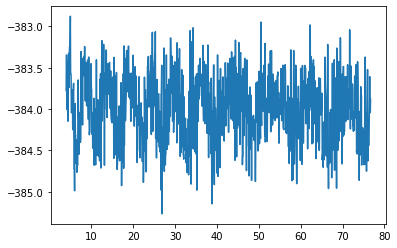

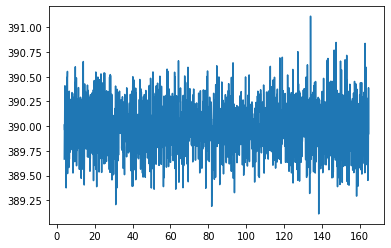

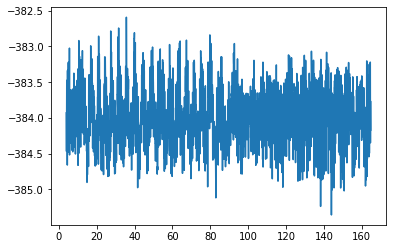

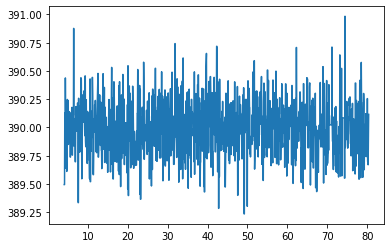

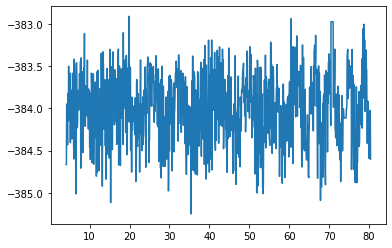

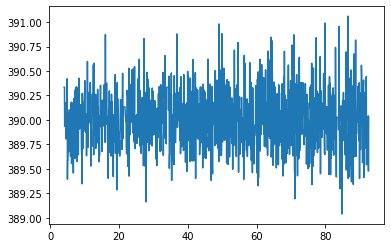

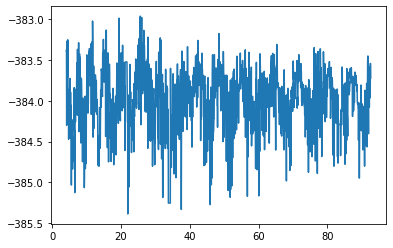

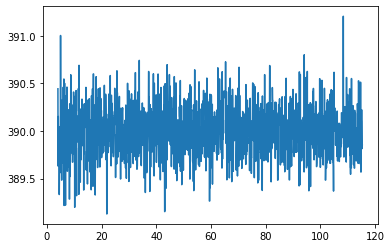

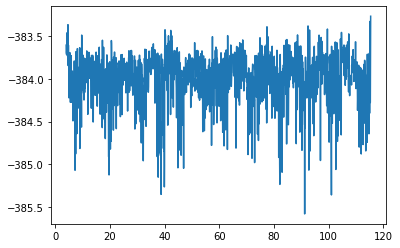

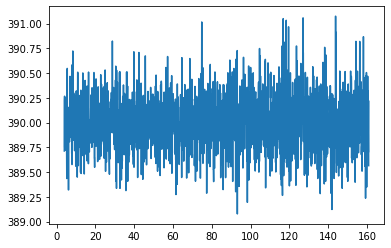

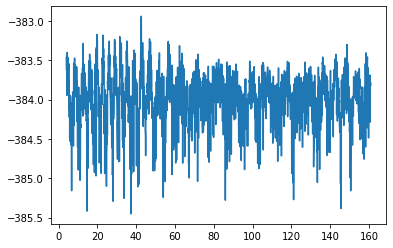

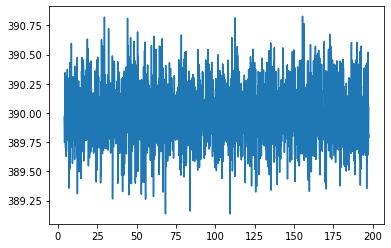

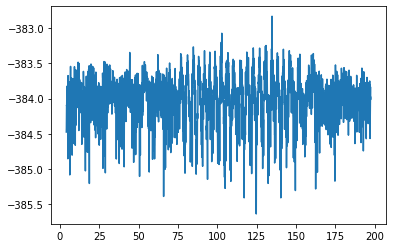

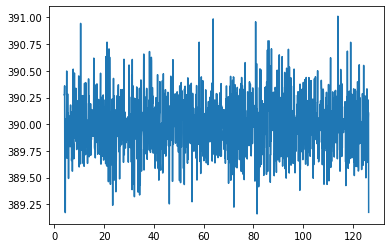

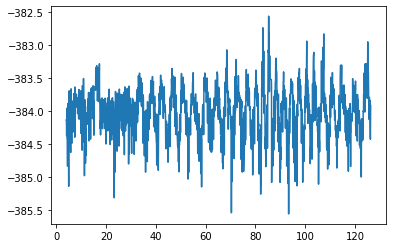

In [7]:
integrated = []
for dset_name in tqdm(dset_names):
    data = load_saturation_data(fname, dset_name)
    integrated.append(data[0])
    plt.figure()
    plt.plot(data[1]['time'], data[1]['laser 1 frequency'])
    plt.figure()
    plt.plot(data[1]['time'], data[1]['laser 2 frequency'])

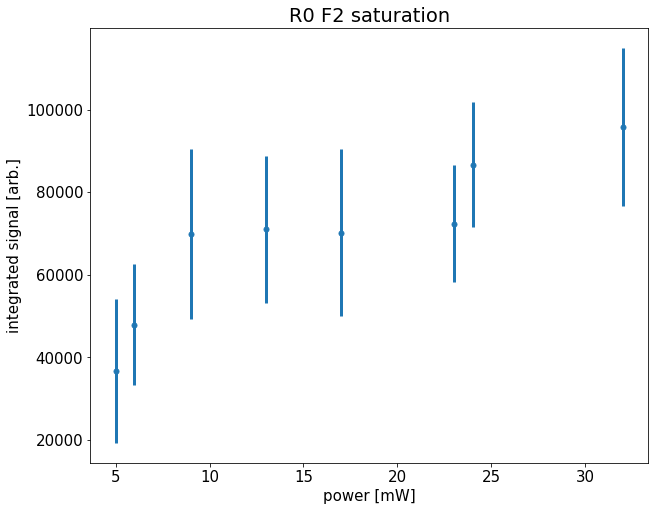

In [8]:
# skipping the first run because it's very noisy, not a lot of data points either

y = {}
for power, dat in zip(powers[1:], integrated[1:]):
    if not y.get(power):
        y[power] = dat
    else:
        y[power] += dat
        
err = {}
for key, val in y.items():
    n, bins = np.histogram(val, density = True)
    popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(val), np.std(val)))
    
#     plt.figure()
#     plt.bar(bins[:-1]+(bins[1]-bins[0])/2, n, width = bins[1]-bins[0])
#     plt.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
#             lw = 3, color = 'C1')
    
    y[key] = popt[0]
    err[key] = popt[1]
    
fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(y.keys(), y.values(), err.values(), fmt = '.', ms = 10, elinewidth = 3)

ax.set_title('R0 F2 saturation')
ax.set_xlabel('power [mW]')
ax.set_ylabel('integrated signal [arb.]')

set_fontsize(ax, 15)
fig.savefig('R0_F2_saturation.png', dpi = 300)